# **Projeto de Otimização das rotas**

## **FASE DO CRISP-DM: ENTENDIMENTO DO NEGÓCIO**

A base de dados trata dos dados de latitude e longitude da casa dos colaboradores da Stellantis (informados pela matrícula) do 1º turno da fábrica, no sentido ida (casa-trabalho). Além disso, a base possui os horários e dias da semana dos colaboradores neste turno.

## **FASE DO CRISP-DM: ENTENDIMENTO DOS DADOS**

Nesta etapa foi realizada a análise exploratória da base. Foi verificado como o dataset é apresentado e suas dimensões. Além disso, foi verificado se a base apresenta valores ausentes.  

In [ ]:
# Importação das bibliotecas necessárias
# para os dados
import numpy as np
import pandas as pd
import math
# para plotagem dos gráficos
import matplotlib.pyplot as plt
import seaborn as sns
# para a análise geoespacial
import folium
import geopy
from geopy.geocoders import Nominatim
# para machine learning
from sklearn import preprocessing, cluster
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import NearestCentroid
import scipy

Análise Exploratória

In [ ]:
# Leitura dos dados
dtf = pd.read_csv('parquespracas.csv',delimiter=';')
dtf.head(5)

,nome_equip_urbano,tipo_equip_urbano,endereco_equip_urbano,codigo_logradouro,lei_equip_urbano,nome_oficial_equip_urbano,area,perimetro,codigo_bairro,nome_bairro,latitude,longitude
0,NaN,Area Verde,Avenida Governador Agamenon Magalhaes,NaN,NaN,NaN,"3243,735391","329,5865855",108,Santo Amaro,-8.038875,-34.876174
1,Dr Jose Vilela,Praça,Avenida Dezessete De Agosto/ Rua Dr Jose Vilel...,66567.0,00448/49,Praça Dr José Vilela,"3042,858638","214,8839095",469,Parnamirim,-8.034091,-34.911571
2,Dr Lula Cabral De Melo,Praça,Avenida Dezessete De Agosto/ Avenida Parnamiri...,66630.0,12917/77,Praça Dr Lula Cabral de Melo,"1893,010563","172,7622162",469,Parnamirim,-8.033198,-34.910294
3,Jornalista Francisco Pessoa De Queiroz Júnior,Praça,Rua Nestor Silva/ Rua Leonardo Bezerra Cavalcante,84255.0,14265/81,Praça Jornalista Francisco Pessoa de Queiroz,"722,7935899","100,7092719",450,Santana,-8.037485,-34.913867
4,Rádio Jornal Do Comercio,Praça,Avenida Dezesste De Agosto/ Rua Leonardo Bezer...,66893.0,00453/46,Praça Rádio Jornal do Comércio,"2724,390231","204,0777537",469,Parnamirim,-8.036971,-34.913944


In [ ]:
# Verificação da dimensão do dataset
print("Apresentando a dimensão dos dados: {}".format(dtf.shape))

# Verificação dos valores ausentes na base
print("Quantidade de valores ausentes em cada coluna:")
print(dtf.isnull().sum())

Apresentando a dimensão dos dados: (505, 12)
Quantidade de valores ausentes em cada coluna:
nome_equip_urbano             29
tipo_equip_urbano              0
endereco_equip_urbano          0
codigo_logradouro             71
lei_equip_urbano             370
nome_oficial_equip_urbano     71
area                           0
perimetro                      0
codigo_bairro                  0
nome_bairro                    0
latitude                       0
longitude                      0
dtype: int64


A partir dos dados acima, pode dizer que a base contém 6506 instâncias e 12 atributos. Porém, só utilizaremos os dados das matrículas, latitudes e longitudes das casas dos colaboradores. Além disso, foi verificado que a base contém valores ausentes. 

## **FASE DO CRISP-DM: PREPARAÇÃO DOS DADOS**

Nesta etapa foi realizada a preparação da base de dados, como por exemplo: verificação da dimensão, remoção dos valores ausentes e remoção das colunas do dataset que não serão utilizadas.

In [ ]:
# Geração de um dataframe apenas com as colunas Matrícula, Latitude e Longitude
dtf = dtf[["latitude","longitude"]].reset_index(drop=True)

# Verificação da dimensão do dataset
print("Apresentando a dimensão do novo dataframe: {}".format(dtf.shape))
dtf.head()

Apresentando a dimensão do novo dataframe: (505, 2)


,latitude,longitude
0,-8.038875,-34.876174
1,-8.034091,-34.911571
2,-8.033198,-34.910294
3,-8.037485,-34.913867
4,-8.036971,-34.913944


In [ ]:
lat = str(dtf.iloc[0][0])
lon = str(dtf.iloc[0][1])
geo=lat+", "+lon

GEOCODIFICAÇÃO ATRAVÉS DO MÓDULO GEOPY

Aqui, será executada uma análise geoespacial, realizando o processamento das coordenadas de latitude e longitude para aplicação a modelos geográficos.

A visualização dessas informações será através de um mapa, por isso é necessário a leitura das coordenadas da área geográfica para iniciá-lo.

In [ ]:
# Obtenção da localização
geolocator = Nominatim(user_agent="MyCoder")
location = geolocator.reverse(geo)
print(location)

# Exibição apenas dos dados de latitude e longitude
location = [location.latitude, location.longitude]
print("[lat, long]:", location)

Avenida Agamenon Magalhães - Pista Local, Vila Ilha Santa Terezinha, Santo Amaro, Recife, Região Geográfica Imediata do Recife, Região Metropolitana do Recife, Pernambuco, Região Nordeste, 50110-000, Brasil
[lat, long]: [-8.039012641169762, -34.876109615193634]


Foi usada a API Nomanatim, que é um software de geocodificação usado para OpenStreetMap, a fim de realizar o processo de geolocalização.

O mapa será gerado com folium, que é um pacote que nos permite traçar mapas interativos sem precisar carregar um arquivo de forma. 

Cada casa será identificada por um círculo azul de igual tamanho.

In [ ]:
# Definição das variáveis como latitude, longitude e matrícula
x, y = 'latitude', 'longitude'

# Fazendo uma cópia do dataframe
data = dtf.copy()

# Inicialização do mapa com o local de partida
map_ = folium.Map(location=location, tiles='OpenStreetMap', zoom_start=11)

# Adicionar os pontos da base de dados ao mapa, através da latitude e longitude
data.apply(lambda row: folium.CircleMarker(location=[row[x],row[y]],fill=True,
                                           popup = folium.Popup(str(['LAT',row[x],'LONG',row[y]]))).add_to(map_), axis=1)

# Plotagem do Mapa
map_

## **FASE DO CRISP-DM: MODELAGEM**

Nesta etapa foi realizada a clusterização de modo a encontrar os grupos de pessoas próximas (clusters) e as paradas ótimas (seus centróides). Foram utilizados dois métodos: Kmeans e aglomerativo hierárquico.

### **1) CLUSTERING - ALGORITMO: K-MEANS**

Aqui será usado o algoritmo K-means. Este algoritmo divide as observações em um número pré-definido de clusters (k), em que cada ponto pertencente ao cluster com a média mais próxima.

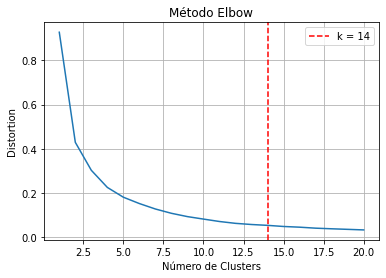

In [ ]:
#Método Elbow

# Definindo X como DataFrame com as latitudes e longitudes:
X = dtf[["latitude","longitude"]]
max_k = 20

# Iterações realizadas no algoritmo K-Means:
distortions = [] # Array das variâncias
for i in range(1, max_k+1):
    if len(X) >= i:
       model = cluster.KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
       model.fit(X)
       distortions.append(model.inertia_) # A cada iteração, adiciona-se o somatório dos erros quadráticos das instâncias de cada cluster ao array distortions.

# Melhor valor de k é o que possui a derivada mais próxima de 0:
k = [i*100 for i in np.diff(distortions,2)].index(min([i*100 for i in np.diff(distortions,2)]))

# Plotagem do gráfico do Método Elbow:
fig, ax = plt.subplots()
ax.plot(range(1, len(distortions)+1), distortions)
ax.axvline(k, ls='--', color='red', label='k = '+str(k)) #legenda
ax.set(title='Método Elbow', xlabel='Número de Clusters', ylabel='Distortion')
ax.legend()
ax.grid(True)
plt.show()

Utilizou-se o Método Elbow para encontrar o melhor valor de k, testando a variância dos dados em relação ao número de clusters. Da execução, obteve-se k = 12 como o melhor valor.

O algoritmo do K-Means foi executado 20 vezes cada uma com 300 iterações, no máximo.


In [ ]:
# Testamos comm k = 650 (10% da base) para que o algoritmo K-Means encontre 650 centróides teóricos.
k = 100

X = dtf[['latitude','longitude']]
dtf_X = X.copy()

# Clusterização
model = cluster.KMeans(n_clusters=k, init='k-means++')
dtf_X['cluster'] = model.fit_predict(X)

# Identificação dos verdadeiros centróides
closest, distances = scipy.cluster.vq.vq(model.cluster_centers_, dtf_X.drop('cluster', axis=1).values)
dtf_X['centroids'] = 0
for i in closest:
    dtf_X['centroids'].iloc[i] = 1

# Adicionando informações de cluster e centróides ao DataSet original:
dtf[['Cluster','Centróides']] = dtf_X[['cluster','centroids']]
dtf.head(10)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,latitude,longitude,Cluster,Centróides
0,-8.038875,-34.876174,31,0
1,-8.034091,-34.911571,93,1
2,-8.033198,-34.910294,93,0
3,-8.037485,-34.913867,87,0
4,-8.036971,-34.913944,87,0
5,-8.037081,-34.914295,87,0
6,-8.055074,-34.891566,59,1
7,-8.039951,-34.878591,31,0
8,-8.038113,-34.918068,11,0
9,-8.085811,-34.884018,44,0


Mesmo tendo obtido 12 como o melhor valor para k, foi utilizado o k = 650 (10% da base) aplicado ao algoritmo K-Means, porque o método Elbow não atendeu a necessidade do datadet, por isso seguiu-se com a outra definição para o valor de k.

Após encontrar esses centróides, eles foram comparados aos centróides de um code book e atribuídos ao código do centróide mais próximo. O code book foi criado com o algoritmo K-Means.

Foram adicionadas duas colunas ao datadet, onde:
- a coluna "Cluster" indica a que aglomerado a observação pertence;
- a coluna "Centróides" indica 1 se uma observação também é o centróide (o mais próximo do centro) e 0 se for de outra forma.


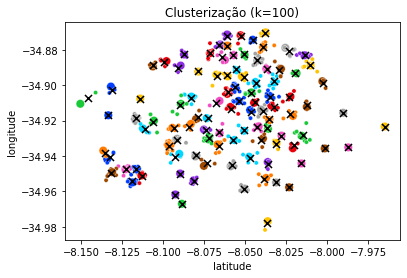

In [ ]:
# Plotagem da Clusterização
fig, ax = plt.subplots()
sns.scatterplot(x="latitude", y="longitude", data=dtf, palette=sns.color_palette("bright",k), hue='Cluster', size="Centróides", size_order=[1,0],
                legend= False, ax=ax).set_title('Clusterização (k='+str(k)+')')
th_centroids = model.cluster_centers_
ax.scatter(th_centroids[:,0], th_centroids[:,1], s=50, c='black', marker="x")

Este gráfico representa a Clusterização e a definição dos 650 centróides realizada pelo algoritmo K-Means, baseando-se nas latitudes e longitudes do DataSet.

In [ ]:
# Exibição dos Clusters no mapa
x, y = "latitude", "longitude"
#p= "Matrícula"
color = "Cluster"
marker = "Centróides"
data = dtf.copy()

# Definindo a cor das colunas:
lst_elements = sorted(list(dtf[color].unique()))
lst_colors = ['#%06X' % np.random.randint(0, 0xFFFFFF) for i in range(len(lst_elements))]
data["color"] = data[color].apply(lambda x: lst_colors[lst_elements.index(x)])

# Definindo a escala do mapa:
scaler = preprocessing.MinMaxScaler(feature_range=(3,15))

# Inicialização do mapa com o local de partida:
map_ = folium.Map(location=location, tiles='OpenStreetMap',zoom_start=11)

# Adicionar os pontos da base de dados ao mapa, através da latitude e longitude:
data.apply(lambda row: folium.CircleMarker(location=[row[x],row[y]], color=row["color"],
                                           popup = folium.Popup(str(['LAT',row[x],'LONG',row[y]])),
                                           fill=True).add_to(map_), axis=1)

# Adicionando a marcação dos centróides:
lst_elements = sorted(list(dtf[marker].unique()))
data[data[marker]==1].apply(lambda row: folium.Marker(location=[row[x],row[y]], icon=folium.Icon(color="black")).add_to(map_), axis=1)

# Plotagem do Mapa:
map_

Através do algoritmo K-Means para agrupar os dados, foi gerado o mapa com a visualização dos clusters e exibição dos centróides, usando um marcador, baseado no conjunto de dados fornecido no início do código.

Verifica-se que a aplicação do algoritmo K-Means gerou uma adequada distribuição dos centróides, porém foi necessário definir um valor de k elevado (comparado ao encontrado no Método Elbow) para refletir a particularidade do conjunto de dados.

Ainda, percebe-se a marcação de pontos em outros estados e países. Provavelmente, isto ocorreu porque o cadastro de endereço desses colaboradores não foi atualizado na base da Stellantis, mas isto será tratado em outro momento. Por ora, o objetivo de aplicar um algoritmo de Clusterização com os dados da Stellantis foi atendido.